In [1]:
#dropbox_path='/home/boareto/Dropbox/'
dropbox_path='/Users/marcelob/Dropbox/'

import sys
import itertools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import special
from scipy.stats.stats import pearsonr 
from scipy.stats import ttest_ind
from sklearn import manifold
from sklearn.decomposition import PCA
import os.path


cmap = plt.cm.get_cmap('Blues')
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})

# calculate fold change
def FC(X, y, absolute=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    fc = np.mean(X[:,y==0], axis=1) - np.mean(X[:,y==1], axis=1)
    if absolute:
        return np.abs(fc)
    return fc

def ttest(X, y, p_value=True, equal_var=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    t, p = ttest_ind(X.T[y==0], X.T[y==1], equal_var=equal_var)
    p[np.isnan(p)] = 1.0
    t[np.isnan(t)] = 0.0
    return t,p

def sum_var(X, y):
    return np.var(X[:,y==0], axis=1) + np.var(X[:,y==1], axis=1)

def suvrel(X, y, gamma=None, p=None, print_gamma=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    
    if gamma==None:
        if p==None:
            print 'Define either gamma or a minimum p-value'
            return 0
        else:
            t = tvalue_from_pvalue(p)
            gamma = 1.0/(t**2 + 2.0)
    elif gamma>0.5:
        print 'gamma>0.5, are you sure?'
        
    w = gamma*FC(X, y)**2 - (1.0 - 2.0*gamma)*sum_var(X,y)
    w[w<0] = 0.0
    
    if print_gamma:
        print 'Suvrel analysis: gamma = ',gamma
    return [w/np.sqrt(np.sum(w**2)), 2*w]

def calculate_tvalue(X, y):
    return FC(X,y)/np.sqrt(np.var(X[:,y==0], axis=1) + np.var(X[:,y==1], axis=1))  

def tvalue_from_pvalue(p):
    return 2.0*special.erfcinv(p)

def pvalue_from_tvalue(t):
    return special.erfc(t/2.0)

def pcorr(x,y, log_scale=False):
    if log_scale:
        x = np.log2(x)
        y = np.log2(y)
    [corr,p] = pearsonr(x, y)
    a,b   = np.polyfit(x, y, 1) 
    return [corr, p, a, b]

def dimensional_reduction(D, pc=[0,1], c='g', clabel=None, cbar=True, clim=None, xticks=[], yticks=[], cticks=None,
                          x_fit=None, cmap='Blues', fs=[9,5], ms=200, marker=None, label=None, ax=None, 
                          return_fit=False, xlim=None, ylim=None):
    if ax==None:
        f = plt.subplots(1, 1, figsize=(fs[0], fs[1]), sharex=True, sharey=True)
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
    if x_fit==None:
        x_fit = PCA(n_components=3).fit(D.T)
    x = x_fit.transform(D.T)

    im = plt.scatter(x[:,pc[0]], x[:,pc[1]], c=c, cmap=cmap, marker='o', s=ms, alpha=0.9)
    if label!=None:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if cbar:
        cbar = plt.colorbar(im, orientation='vertical')
        if cticks!=None:
            cbar.ax.set_yticks(set(c))
            cbar.ax.set_yticklabels(cticks)
        if clabel!=None:
            if clim!=None:
                plt.clim([clim[0], clim[1]])
            else:
                plt.clim([np.min(c), np.max(c)])
            cbar.set_label(clabel)
    if xlim!=None:
        plt.xlim(xlim)
    if ylim!=None:
        plt.ylim(ylim)
    if xticks!=None:
        plt.xticks(xticks)
    if yticks!=None:
        plt.yticks(yticks)
    ax.autoscale_view()
    if return_fit:
        return x_fit

In [2]:
# Reading data form .counts files
# data mapped with Bowtie and gene counts were obtained by HTSeq.

path_counts = '../counts/'
lists = '../list_counts.txt'
df_names  = []
col_names = []
for l in pd.read_csv(lists, header=None, sep='\n').values:
    if os.path.isfile(path_counts+l[0]): 
        col_names += [l[0]]
        df_names  += [pd.read_csv(path_counts+l[0], header=None, names=['gene_name', 'counts'], 
                      index_col=0, sep='\t')]

In [3]:
D = {}
D['raw_data'] = pd.concat(df_names, axis=1)
D['raw_data'].columns = col_names
        
l_info = ['__no_feature','__ambiguous','__too_low_aQual','__not_aligned','__alignment_not_unique'] 
D['info']     = D['raw_data'].loc[l_info]
D['raw_data'] = D['raw_data'].drop(l_info)
# plt.hist(np.sum(D['raw_data'].values, axis=0))
#D['info']

In [4]:
col_names = ['WT1_rep1_1', 'WT1_rep1_2', 'WT2_rep1_1', 'WT2_rep1_2', 'WT3_rep1_1', 'WT3_rep1_2',
             'KO1_rep1_1', 'KO1_rep1_2', 'KO2_rep1_1', 'KO2_rep1_2', 'KO3_rep1_1', 'KO3_rep1_2',
             'WT1_rep2_1', 'WT1_rep2_2', 'WT2_rep2_1', 'WT2_rep2_2', 'WT3_rep2_1', 'WT3_rep2_2',
             'KO1_rep2_1', 'KO1_rep2_2', 'KO2_rep2_1', 'KO2_rep2_2', 'KO3_rep2_1', 'KO3_rep2_2']
D['raw_data'].columns = col_names
D['info'].columns = col_names

# Normalization (counts per million)
D['data'] = np.log2( (D['raw_data']*1.0e+6)/np.sum(D['raw_data'].values, axis=0) + 1.0)
D['data'].head()

,WT1_rep1_1,WT1_rep1_2,WT2_rep1_1,WT2_rep1_2,WT3_rep1_1,WT3_rep1_2,KO1_rep1_1,KO1_rep1_2,KO2_rep1_1,KO2_rep1_2,...,WT2_rep2_1,WT2_rep2_2,WT3_rep2_1,WT3_rep2_2,KO1_rep2_1,KO1_rep2_2,KO2_rep2_1,KO2_rep2_2,KO3_rep2_1,KO3_rep2_2
gene_name,,,,,,,,,,,,,,,,,,,,,
0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382553,0.264188,...,0.150402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610007P14Rik,7.458578,7.417549,6.969559,6.999564,7.064218,7.057795,6.871433,6.868833,7.162987,7.287637,...,6.669006,6.646166,6.551343,6.658116,6.701864,6.698546,7.350122,7.333247,6.234811,6.241105
0610009B22Rik,7.698226,7.683962,6.260178,6.371115,6.002145,6.024860,6.112719,6.087593,6.870280,6.810334,...,5.794408,5.666555,6.167321,6.039617,6.092498,6.232326,5.652620,5.592539,5.288440,5.240599
0610009E02Rik,2.930150,2.628915,0.672336,0.743669,0.407466,0.282850,1.502303,1.242403,1.734638,1.968616,...,1.404999,1.186970,0.449229,0.447783,0.195233,0.100147,1.792952,1.747646,0.917683,1.070269
0610009L18Rik,3.234762,2.993808,2.366128,2.473111,0.984818,0.900246,3.058626,3.023815,3.408099,3.284185,...,2.816255,2.753890,3.557857,3.863628,3.255445,3.495589,3.841019,3.746891,2.663224,2.581562


In [5]:
D['rep1'] = D['raw_data'][D['raw_data'].columns[ 0:12]]
D['rep2'] = D['raw_data'][D['raw_data'].columns[12:24]]

columns = ['WT1','WT2','WT3','KO1','KO2','KO3']
index   = D['raw_data'].index
D['sum_1']   = pd.DataFrame(columns=columns, index=index)
D['sum_2']   = pd.DataFrame(columns=columns, index=index)
D['sum'  ]   = pd.DataFrame(columns=columns, index=index)
for k in columns:
    D['sum_1'][k] = (D['rep1'][k+'_rep1_1'] + D['rep1'][k+'_rep1_2'])
    D['sum_2'][k] = (D['rep2'][k+'_rep2_1'] + D['rep2'][k+'_rep2_2'])
    D['sum'][k] = (D['sum_1'][k] + D['sum_2'][k])
    
for k in ['sum_1', 'sum_2', 'sum']:
    D[k] = np.log2( (D[k]*1.0e+6)/np.sum(D[k].values, axis=0) + 1.0)

y = np.array([0,0,0,1,1,1])

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


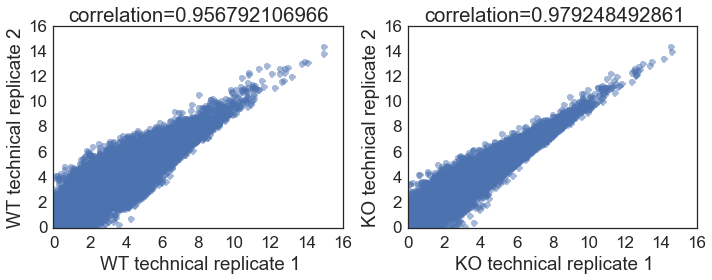

In [6]:
f = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
# ax.text(-3.0, 16.5, 'A', fontsize=26)
# ax.text(16.5, 16.5, 'B', fontsize=26)
wt_1 = np.mean(D['sum_1'].values[:,y==0], axis=1)
wt_2 = np.mean(D['sum_2'].values[:,y==0], axis=1)
plt.plot(wt_1, wt_2, 'o', alpha=0.5)
plt.title('correlation='+str(pcorr(wt_1, wt_2)[0]))
plt.xlabel('WT technical replicate 1')
plt.ylabel('WT technical replicate 2')

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ko_1 = np.mean(D['sum_1'].values[:,y==1], axis=1)
ko_2 = np.mean(D['sum_2'].values[:,y==1], axis=1)
plt.plot(ko_1, ko_2, 'o', alpha=0.5)
plt.title('correlation='+str(pcorr(ko_1, ko_2)[0]))
plt.xlabel('KO technical replicate 1')
plt.ylabel('KO technical replicate 2')
plt.tight_layout()
#plt.savefig('./figures/Correlation_Technical_Replicates.pdf', format='pdf', dpi=200)

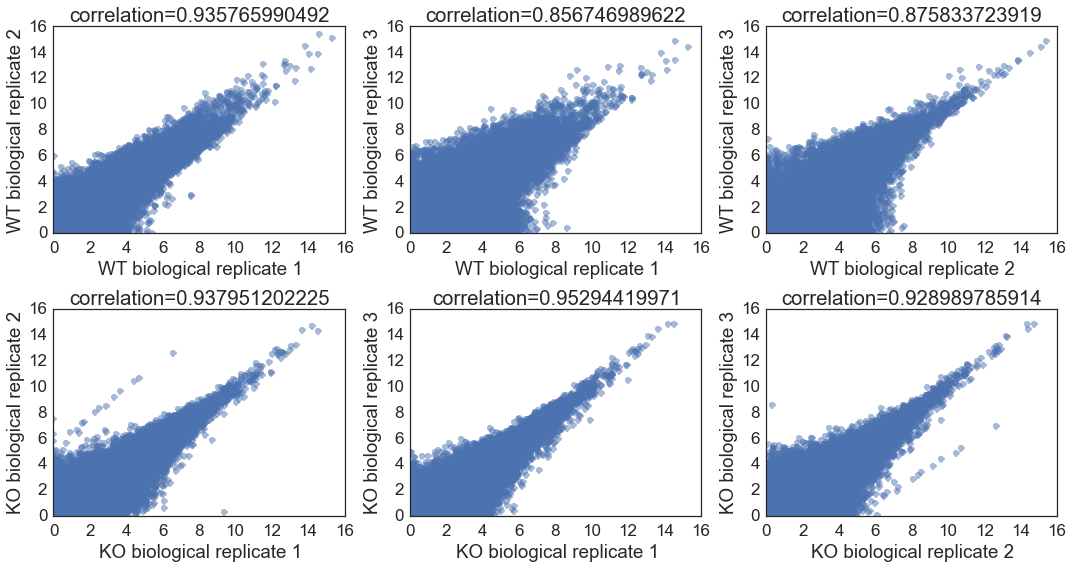

In [7]:
f = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)

for i in range(3):
    for j in range(3):
        if j>i:
            ax = plt.subplot2grid((2, 3), (0, i+j-1), colspan=1, rowspan=1)
            wt_1 = D['sum_1'].values[:,i]
            wt_2 = D['sum_1'].values[:,j]
            plt.plot(wt_1, wt_2, 'o', alpha=0.5)
            plt.title('correlation='+str(pcorr(wt_1, wt_2)[0]))
            plt.xlabel('WT biological replicate '+str(i+1))
            plt.ylabel('WT biological replicate '+str(j+1))
            ax = plt.subplot2grid((2, 3), (1, i+j-1), colspan=1, rowspan=1)
            ko_1 = D['sum_1'].values[:,3+i]
            ko_2 = D['sum_1'].values[:,3+j]
            plt.plot(ko_1, ko_2, 'o', alpha=0.5)
            plt.title('correlation='+str(pcorr(ko_1, ko_2)[0]))
            plt.xlabel('KO biological replicate '+str(i+1))
            plt.ylabel('KO biological replicate '+str(j+1))

plt.tight_layout()
#plt.savefig('./figures/Correlation_Biological_Replicates.pdf', format='pdf', dpi=200)

In [8]:
X = D['sum'].values
n, m = X.shape
s = suvrel(X, y, gamma=1.0/3.0)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


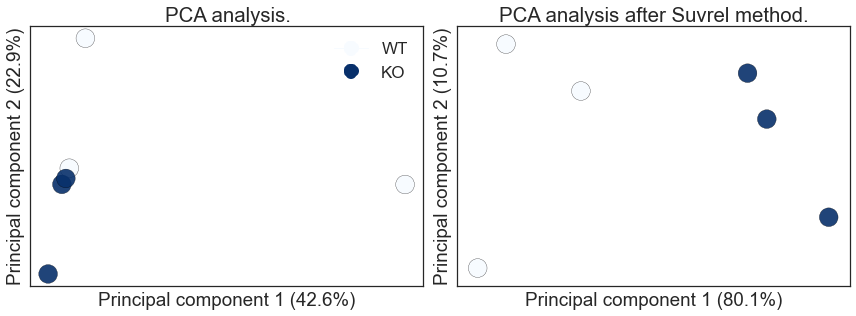

In [9]:
f = plt.subplots(1, 2, figsize=(12, 4.5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
x_fit = dimensional_reduction(X, c=y, xticks=[], yticks=[], ax=ax, cbar=False, return_fit=True, ms=350)
plt.xlabel('Principal component 1 ('+str(100*round(x_fit.explained_variance_ratio_[0], 3))+'%)')
plt.ylabel('Principal component 2 ('+str(100*round(x_fit.explained_variance_ratio_[1], 3))+'%)')
plt.title('PCA analysis.')
leg0 = mlines.Line2D([], [], c=cmap(0.0), marker='o', linewidth=1, 
                          markersize=15, label='WT')
leg1 = mlines.Line2D([], [], c=cmap(1.0), marker='o', linewidth=0,
                          markersize=15, label='KO')
plt.legend(handles=[leg0, leg1])

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
x_fit = dimensional_reduction(X*np.dot(s[0].reshape(n,1),np.ones((1,m))), 
                      c=y, xticks=[], yticks=[], ax=ax, cbar=False, return_fit=True, ms=350)
plt.xlabel('Principal component 1 ('+str(100*round(x_fit.explained_variance_ratio_[0], 3))+'%)')
plt.ylabel('Principal component 2 ('+str(100*round(x_fit.explained_variance_ratio_[1], 3))+'%)')
plt.title('PCA analysis after Suvrel method.')
plt.tight_layout()
#plt.savefig('./figures/PCA_analysis.pdf', format='pdf', dpi=200)

In [10]:
n_topgenes = 1000

orig_stdout = sys.stdout
f = open('Suvrelv2_top1000_withFC.txt', 'w')
sys.stdout = f

fc = FC(X,y)

top_fc = fc[np.argsort(-s[0])[:n_topgenes]]
l_topgenes = D['sum'].index[np.argsort(-s[0])[:n_topgenes]]
for g in range(n_topgenes):
    print l_topgenes[g], '\t', -top_fc[g]
    
sys.stdout = orig_stdout
f.close()

In [11]:
print np.sum(top_fc>0), np.sum(top_fc<0)

161 839


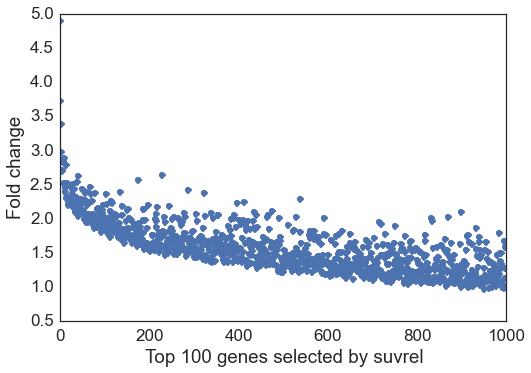

In [12]:
plt.plot(np.abs(fc[np.argsort(-s[0])[:1000]]), 'o')
plt.xlabel('Top 100 genes selected by suvrel')
plt.ylabel('Fold change')

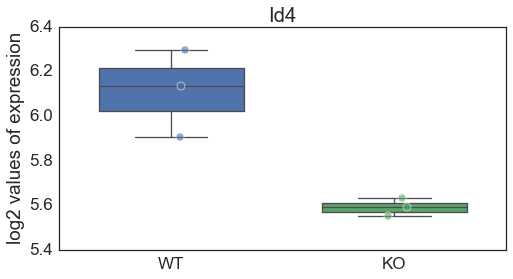

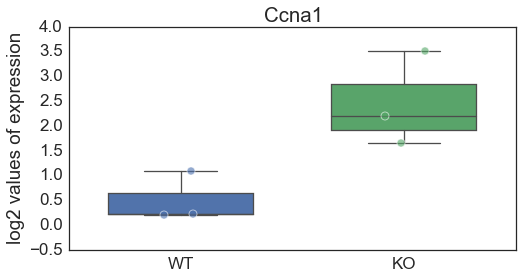

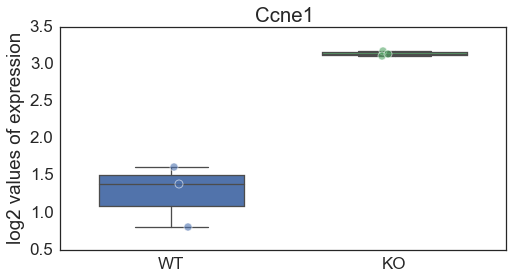

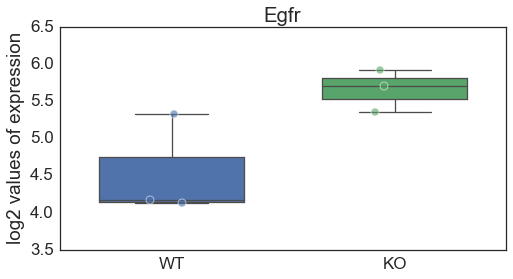

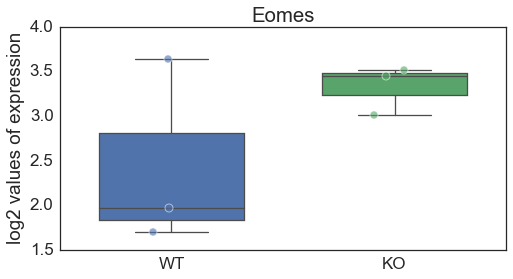

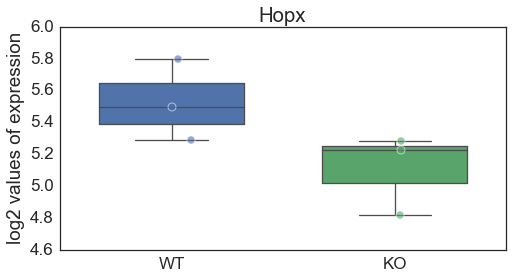

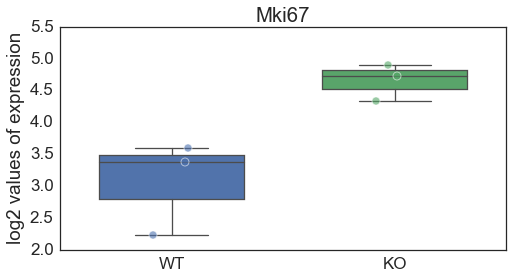

In [13]:
l_g = ['Id4', 'Ccna1', 'Ccne1', 'Egfr', 'Eomes', 'Hopx', 'Mki67'] 

for g in l_g:
    plt.figure(figsize=(8,4))
    data = [np.mean(D['sum'].loc[[g]].values[:,y==0], axis=0), 
            np.mean(D['sum'].loc[[g]].values[:,y==1], axis=0),
           ]
    sns.boxplot(  data=data, saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=data, jitter=True,  size=8, linewidth=0.9, edgecolor='w', marker='o', alpha=0.6)
    plt.title(g)    
    plt.xticks([0, 1],['WT','KO'])
    plt.savefig('./barplots/'+g+'.pdf', format='pdf', dpi=1)
    plt.ylabel('log2 values of expression')
#    plt.xlabel(g)

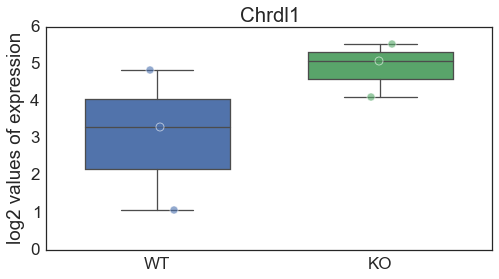

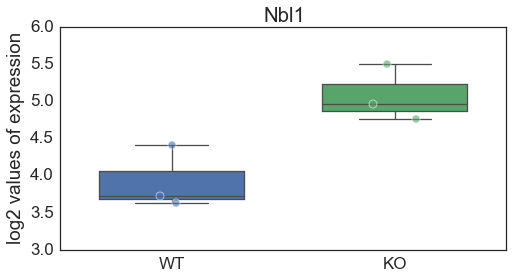

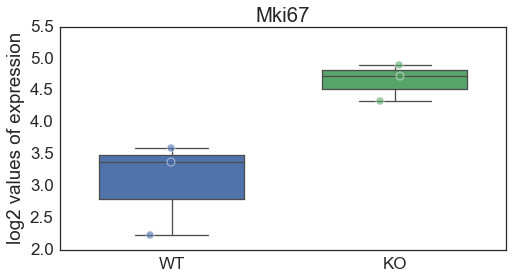

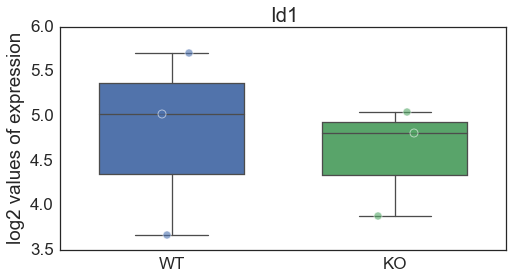

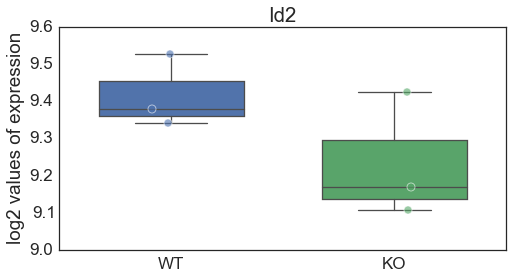

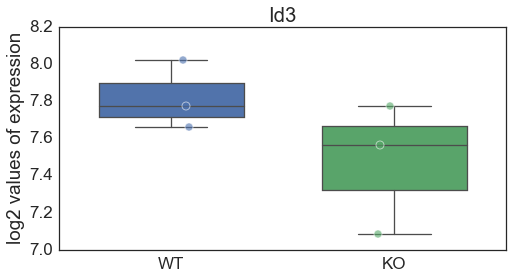

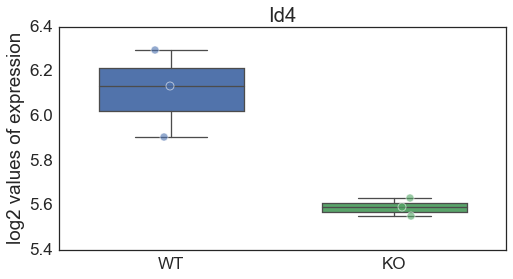

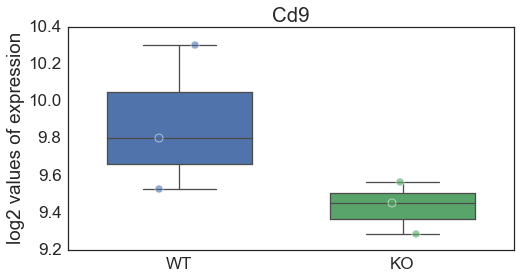

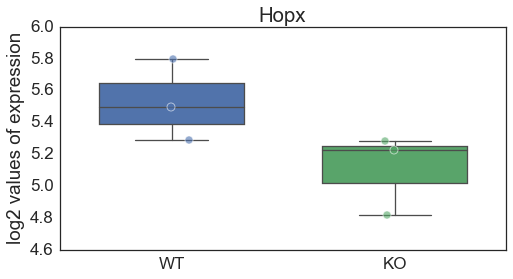

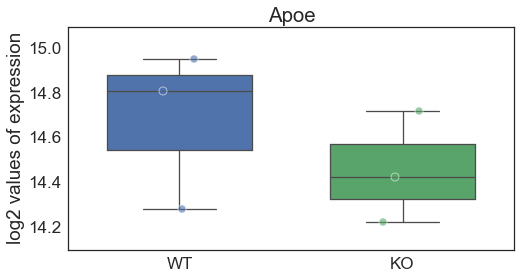

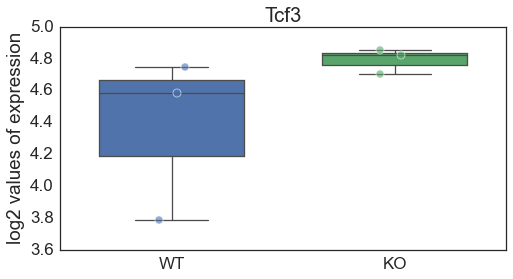

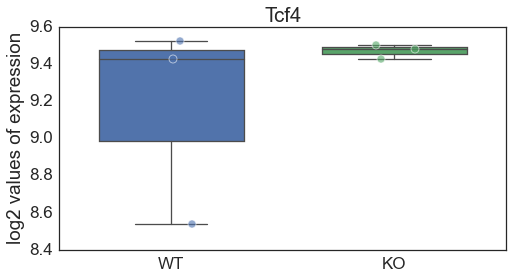

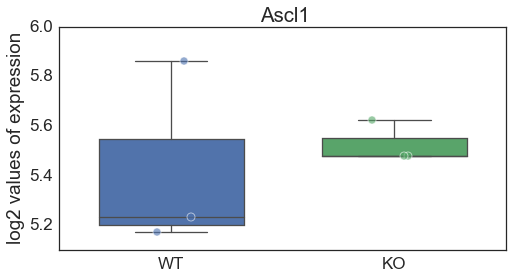

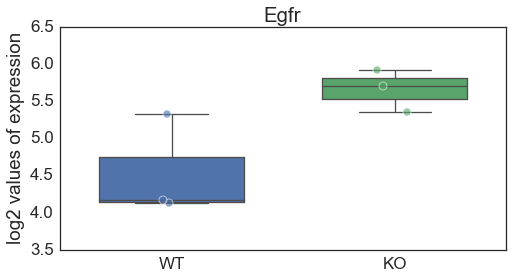

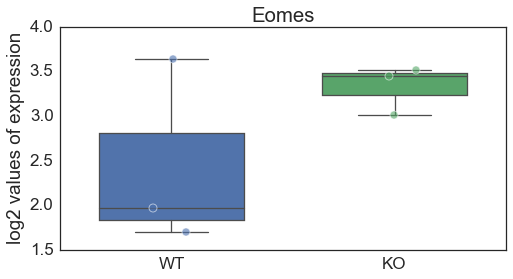

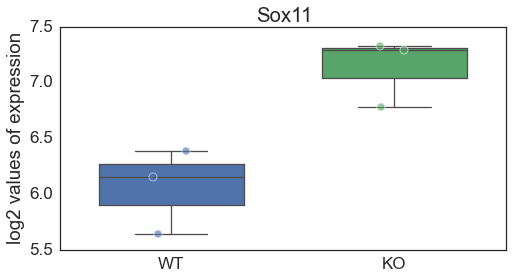

In [14]:
l_g = ['Chrdl1', 'Nbl1','Mki67', 'Id1', 'Id2', 'Id3', 'Id4', 'Cd9', 'Hopx', 'Apoe', 'Tcf3', 'Tcf4',
       'Ascl1', 'Egfr', 'Eomes', 'Sox11'] 

for g in l_g:
    plt.figure(figsize=(8,4))
    data = [np.mean(D['sum'].loc[[g]].values[:,y==0], axis=0), 
            np.mean(D['sum'].loc[[g]].values[:,y==1], axis=0),
           ]
    sns.boxplot(  data=data, saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=data, jitter=True,  size=8, linewidth=0.9, edgecolor='w', marker='o', alpha=0.6)
    plt.title(g)    
    plt.xticks([0, 1],['WT','KO'])
    plt.savefig('./barplots/'+g+'.pdf', format='pdf', dpi=1)
    plt.ylabel('log2 values of expression')
#    plt.xlabel(g)